<a href="https://colab.research.google.com/github/10Vaibhav/HMI/blob/main/HyperSpectral_Classification_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install earthpy

# Import Libraries


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import earthpy.spatial as es
import earthpy.plot as ep
import plotly.graph_objects as go
import plotly.express as px
from scipy.io import loadmat
import pandas as pd
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report)

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tqdm import tqdm
from numpy.random import seed
from time import time

In [10]:
seed(11)

# Load Data

In [11]:
data = loadmat('Pavia.mat')

In [12]:
print(data)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Fri May 20 18:20:56 2011', '__version__': '1.0', '__globals__': [], 'pavia': array([[[ 854,  601,  350, ..., 3664, 3636, 3643],
        [ 527,  642,  575, ..., 3834, 3725, 3768],
        [ 374,  322,  179, ..., 4318, 4311, 4321],
        ...,
        [ 367,  432,  461, ..., 2582, 2504, 2512],
        [ 261,  311,  366, ..., 2269, 2174, 2163],
        [1059,  678,  403, ..., 2245, 2135, 2136]],

       [[1060,  909,  596, ..., 2963, 2967, 2974],
        [ 707,  757,  646, ..., 3508, 3534, 3648],
        [ 143,  419,  417, ..., 4650, 4612, 4638],
        ...,
        [ 465,  547,  537, ..., 3156, 3052, 3035],
        [ 884,  615,  401, ..., 2792, 2667, 2639],
        [ 756,  401,  213, ..., 2600, 2484, 2445]],

       [[ 532,  545,  594, ..., 1675, 1653, 1680],
        [ 523,  491,  321, ..., 3339, 3349, 3403],
        [ 816,  681,  369, ..., 4627, 4600, 4650],
        ...,
        [ 408,  539,  436, ..., 3099, 3005, 30

In [13]:
# X data (1096, 715, 102) ---> HyperSpectral Satellite Data.
# here, beacause we are using one dimensional CNN like traditional algo. so 1D CNN does not accept a 2D array, it just accespt a vector data, so for that we need to reshpae the data as --> (1096*715, 102) by this we have 783640 rows.
# the 1D CNN will now process each pixel's spectral profile as a separate input sample. Each sample is a 1D array of length 102, which is exactly what the 1D CNN expects.
# for each pixel, the CNN analyzes patterns accross the spectral dimension(wavelength) rather than spatial patterns, which is effective for material identification.
data = loadmat('Pavia')['pavia']

In [14]:
print(data)

[[[ 854  601  350 ... 3664 3636 3643]
  [ 527  642  575 ... 3834 3725 3768]
  [ 374  322  179 ... 4318 4311 4321]
  ...
  [ 367  432  461 ... 2582 2504 2512]
  [ 261  311  366 ... 2269 2174 2163]
  [1059  678  403 ... 2245 2135 2136]]

 [[1060  909  596 ... 2963 2967 2974]
  [ 707  757  646 ... 3508 3534 3648]
  [ 143  419  417 ... 4650 4612 4638]
  ...
  [ 465  547  537 ... 3156 3052 3035]
  [ 884  615  401 ... 2792 2667 2639]
  [ 756  401  213 ... 2600 2484 2445]]

 [[ 532  545  594 ... 1675 1653 1680]
  [ 523  491  321 ... 3339 3349 3403]
  [ 816  681  369 ... 4627 4600 4650]
  ...
  [ 408  539  436 ... 3099 3005 3006]
  [ 393  447  476 ... 3172 3048 3032]
  [ 798  615  489 ... 3039 2876 2800]]

 ...

 [[ 689  560  701 ... 1314 1265 1271]
  [ 497  785 1029 ... 1226 1237 1255]
  [ 947  634  587 ... 1260 1232 1252]
  ...
  [ 812  483  220 ... 1791 1699 1641]
  [ 840  538  494 ... 1506 1456 1411]
  [ 187  305  343 ... 1512 1415 1399]]

 [[ 895  586  635 ... 1302 1281 1290]
  [ 211  373

In [15]:
gt = loadmat('Pavia_gt.mat')

In [16]:
print(gt)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Fri May 20 18:26:22 2011', '__version__': '1.0', '__globals__': [], 'pavia_gt': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}


In [17]:
# Y data (labels) --> class
gt = loadmat('Pavia_gt.mat')['pavia_gt']

In [18]:
print(gt)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [19]:
print(f'Data Shpae: {data.shape[:-1]}\nNumber of Bands: {data.shape[-1]}')

Data Shpae: (1096, 715)
Number of Bands: 102


In [20]:
df = pd.DataFrame(data.reshape(data.shape[0]*data.shape[1], -1))

In [21]:
df.columns = [f'band{i}' for i in range(1,df.shape[-1]+1)]

In [22]:
df['class'] = gt.ravel()

In [23]:
df.head()

band1  band2  band3  band4  band5  band6  band7  band8  band9  band10  ...  \
0    854    601    350    266    138    118    178    194    257     269  ...   
1    527    642    575    294    123    168    207    154    209     299  ...   
2    374    322    179     87    169    268    360    339    286     309  ...   
3    706    520    560    572    425    243    271    272    258     276  ...   
4   1120   1027    592    414    407    463    417    365    332     334  ...   

   band94  band95  band96  band97  band98  band99  band100  band101  band102  \
0    3759    3773    3779    3752    3690    3671     3664     3636     3643   
1    3873    3902    3921    3861    3854    3882     3834     3725     3768   
2    4443    4472    4428    4353    4306    4284     4318     4311     4321   
3    3972    4006    4032    3975    3946    3954     3944     3936     3939   
4    4502    4485    4479    4445    4364    4290     4268     4235     4272   

   class  
0      0  
1      0  
2      0  
3      0  
4      0  

[5 rows x 103 columns]

In [24]:
df.shape

(783640, 103)

# Data Visualization

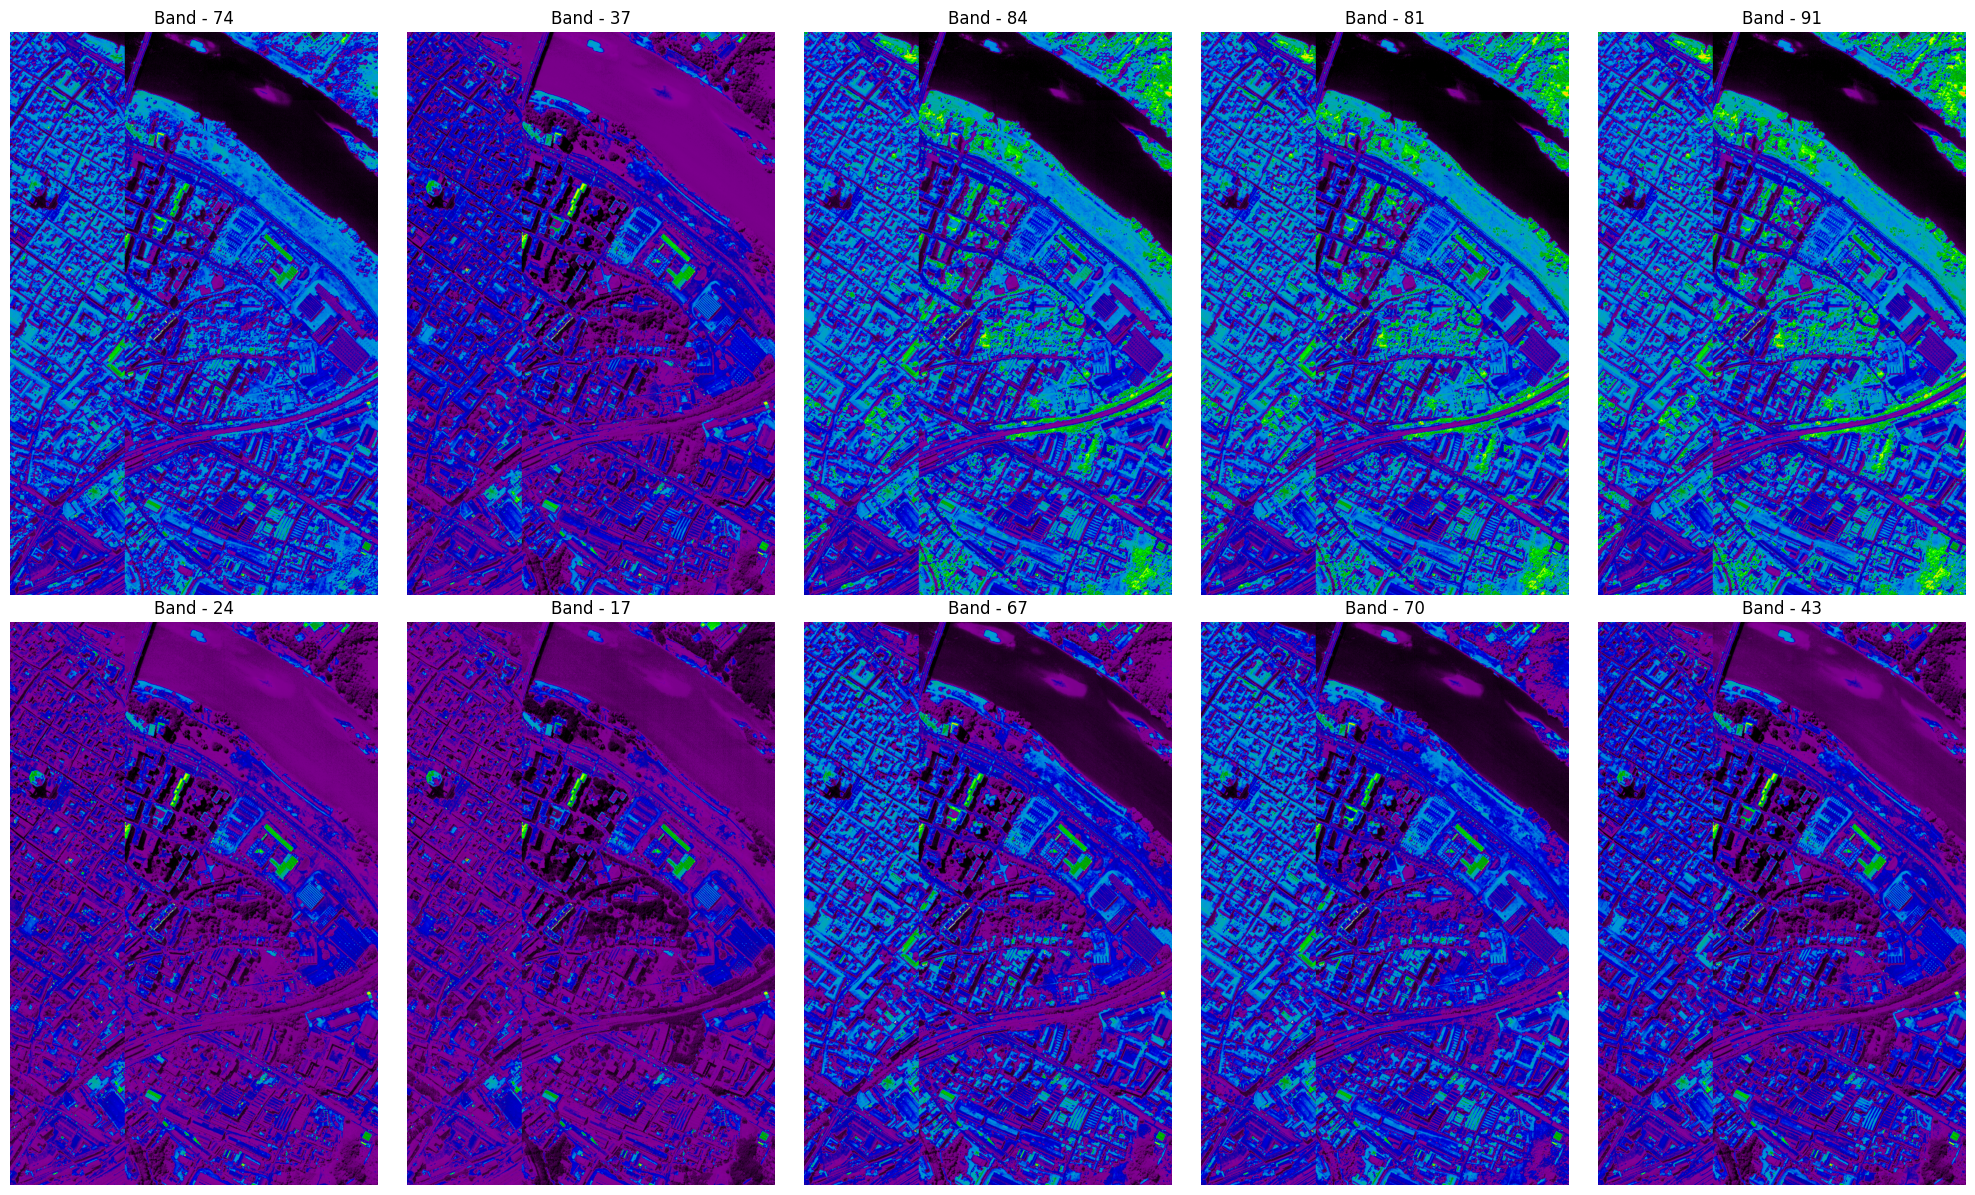

In [28]:
fig = plt.figure(figsize = (20, 12))

ax = fig.subplots(2,5)

for i in range(2):
  for j in range(5):
    c = np.random.randint(103)
    ax[i][j].imshow(data[:,:,c], cmap='nipy_spectral')
    ax[i][j].axis('off')
    ax[i][j].title.set_text(f"Band - {c}")

plt.tight_layout()
plt.show()

# RGB Composite Image

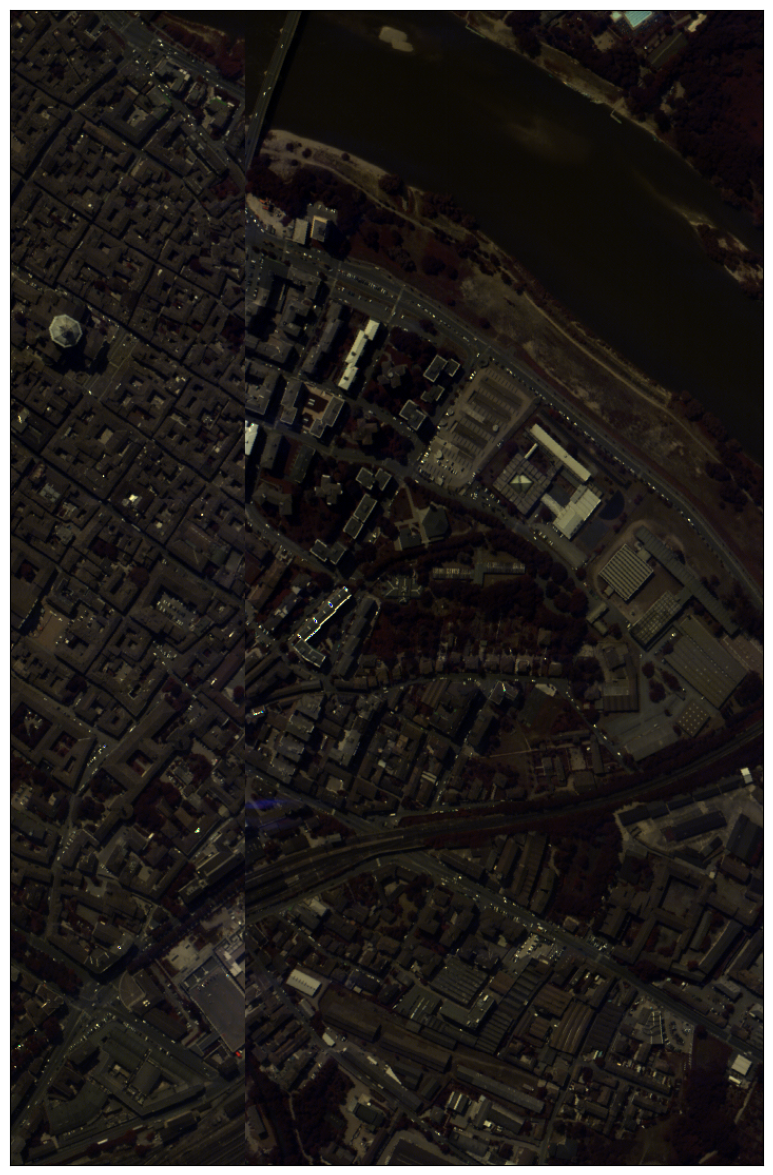

In [30]:
mdata = np.moveaxis(data, -1, 0)

ep.plot_rgb(mdata, (29,19,2), figsize=(15,15))

plt.show()

# GroundTruth Visualization

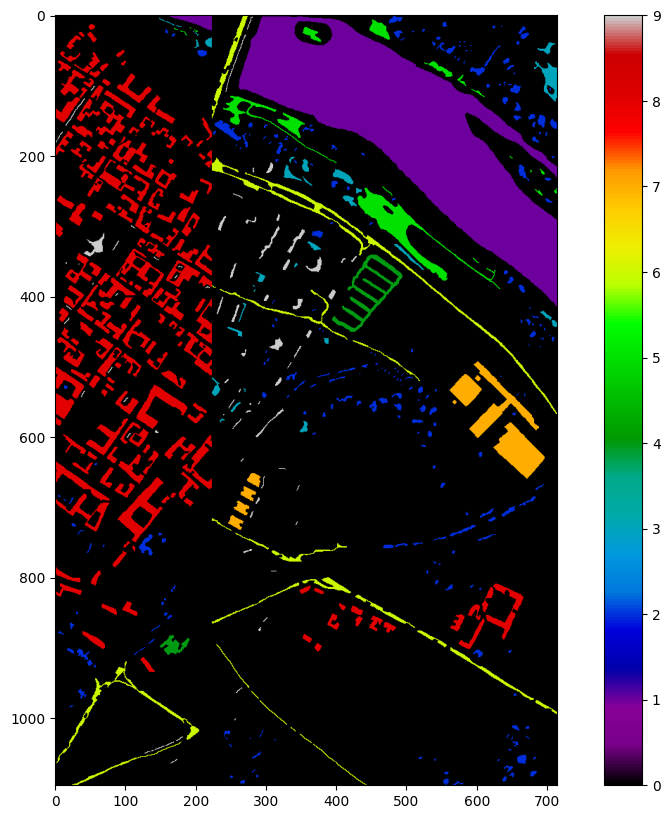

In [31]:
def plot_data(data):
  fig = plt.figure(figsize=(12, 10))
  plt.imshow(data, cmap='nipy_spectral')
  plt.colorbar()
  plt.axis('on')
  plt.show()

plot_data(gt)